# Notebook 1: Afferents

### General Overview

The afferents, also known as hair fields, transform a time course of joint angles into $N_\text{h}$ hair angles. These hair angles are then converted into currents, which run into mechanosensory neurons. The mechanosensory neurons further convert these currents into spike trains. Their spiking dynamics are optimized to closely resemble experimental spiking dynamics [1].


>[1] Okada, J., & Toh, Y. (2001). Peripheral representation of antennal orientation by the scapal hair plate of the cockroach Periplaneta americana. Journal of experimental biology, 204(24), 4301-4309.

### Cell-by-Cell Description

#### Importing Modules and Creating Folders

This cell serves to import general functions, modules, and dictionaries from the 'general' module. Additionally, it imports the hair field and AdEx classes, which is integral to subsequent analyses. The hair field class converts joint angles into hair angles and the AdEx class is used as a model for the mechanosensory neuron, see 'classes.py' for more information.

In [1]:
# Import necessary functions, modules and dictionaries from the 'general' module
from general import *

# Import class the hairfield and adex classes
from classes import HairField
from classes import AdEx

# Create a folder named 'images' and subfolder 'images/afferents' if it does not already exist 
# This is where figures (results) will be saved
create_folder_if_not_exists('images')
create_folder_if_not_exists('images/afferents')

Folder 'images' already exists.
Folder 'images/afferents' already exists.


#### Analyzing the Binary Hair Plate Model

To explore the behavior of the hair plate model, let's set up a hypothetical scenario:

- A hair field consists of 10 hairs.
- The domain of the hair plate spans from 0$\degree$ to 180$\degree$.
- The minimum and maximum deflection of each hair is 0$\degree$ and 90$\degree$, respectively.
- There's an overlap of 4$\degree$ between adjacent hairs.

To cover the full domain of the hair plate and show its characteristics, we generate joint angles ranging from -20$\degree$ to 200$\degree$. After creating an instance of the HairField class with these parameters, we convert these joint angles into $N_\text{h} = 10$ hair angles.

In [2]:
# Define parameters for the hair field
parameters_hair_field = {
    'N_hairs': 10,                # Number of hairs
    'max_joint_angle': 180,       # Maximum of the joint angle working range
    'min_joint_angle': 0,         # Minimum of the joint angle working range
    'max_angle': 90,              # Maximum angle
    'overlap': 4                  # Overlap factor
}

# Generate joint angles from -20, to 200 with 2000 steps
joint_angle = np.linspace(-20, 200, num=2000)

# Create an instance of the HairField class with the specified parameters, calculate the receptive field, and make it binary (two directional).
hair_field = HairField(parameters_hair_field)
hair_field.get_receptive_field()
hair_field.get_double_receptive_field()

# Obtain hair angles corresponding to the given joint angles
hair_angles = hair_field.get_hair_angle(joint_angle)

##### Binary Hair Plate Connected to Position DIN

plotted as follows:
 
- The joint angles are plotted against the corresponding hair angles, for both hair fields. Note that half of the hairs are plotted (the hairs connected to the position DIN)
- Shading indicates the overlaps between receptive fields.
- The generated figures are saved in the directory 'images/afferents/'.

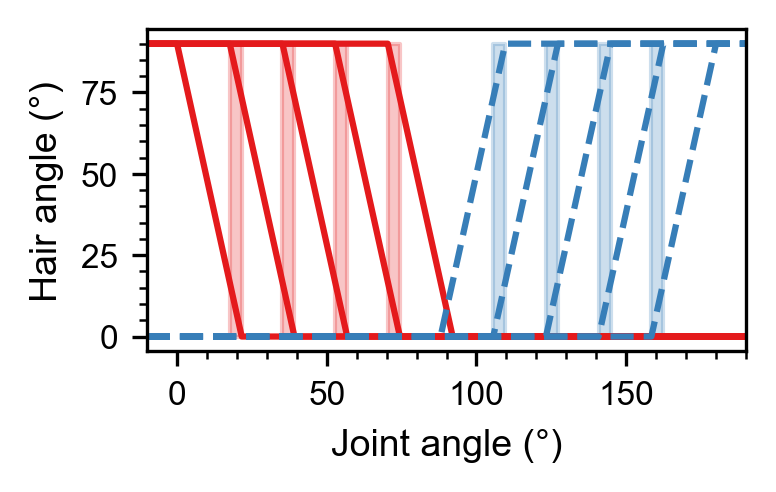

In [3]:
# Create a new figure and axis object
fig, ax = plt.subplots(figsize=constants['figsize_halfcolumn'])

# Determine indices for dividing the hair angles into positive and negative fields
n_2 = int(hair_field.N_hairs / 2)
n_4 = int(n_2 / 2)

# Plot hair angles for the positive hair field
plt.plot(joint_angle, hair_angles[:, n_4], color=custom_colors[0], linestyle=custom_linestyles[0])
plt.plot(joint_angle, hair_angles[:, 1 + n_4:n_2], color=custom_colors[0], linestyle=custom_linestyles[0])

# Plot hair angles for the negative hair field
plt.plot(joint_angle, hair_angles[:, n_2 + n_4], color=custom_colors[1], linestyle=custom_linestyles[1])
plt.plot(joint_angle, hair_angles[:, 1 + n_2 + n_4:], color=custom_colors[1], linestyle=custom_linestyles[1])

# Fill the area between receptive fields for the positive hair field
for i in range(n_4 - 1):
    plt.fill_between([hair_field.receptive_field[0, n_4 + i + 1], hair_field.receptive_field[1, n_4 + i]], [90, 90], 
                     color=custom_colors[0],
                     alpha=0.25)

# Fill the area between receptive fields for the negative hair field
for i in range(n_4 - 1):
    plt.fill_between([hair_field.receptive_field[0, n_2 + n_4 + i + 1], hair_field.receptive_field[1, n_2 + n_4 + i]], [90, 90],
                     color=custom_colors[1],
                     alpha=0.25)

# Set plot labels etc. 
ax.set_xlabel("Joint angle (°)")
ax.set_ylabel("Hair angle (°)")
ax.set_xlim(-10, 190)
ax.minorticks_on()

fig.tight_layout(pad=parameters['pad'])
fig.savefig('images/afferents/P1_fig2a.png')

##### Binary Hair Plate Connected to Velocity DIN

Same as before with the following changes:
- All hairs are connected to the velocity DIN, and therefore plotted.
- The overlap region is omitted for clarity.

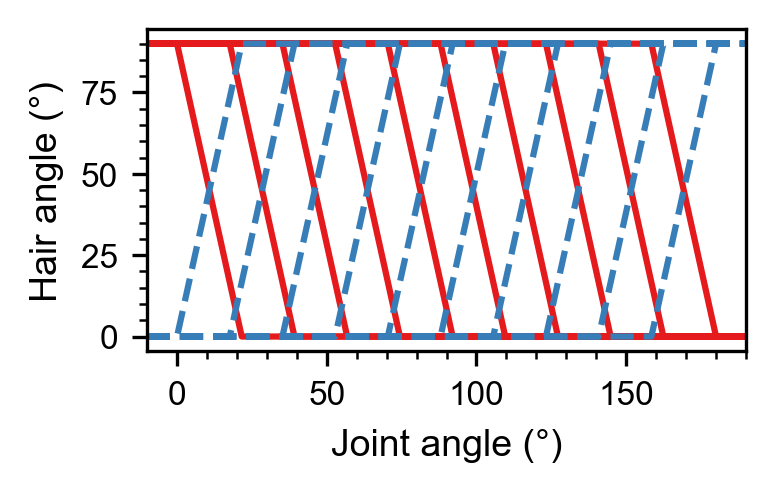

In [4]:
# Create a new figure and axis object
fig, ax = plt.subplots(figsize=constants['figsize_halfcolumn'])

# Plot hair angles for the positive hair field
plt.plot(joint_angle, hair_angles[:, :n_2], color=custom_colors[0], linestyle=custom_linestyles[0])

# Plot hair angles for the negative hair field
plt.plot(joint_angle, hair_angles[:, n_2:], color=custom_colors[1], linestyle=custom_linestyles[1])

# Set plot labels etc.     
ax.set_xlabel("Joint angle (°)")
ax.set_ylabel("Hair angle (°)")
ax.set_xlim(-10, 190)
ax.minorticks_on()

# Save the figures
fig.tight_layout(pad=parameters['pad'])
fig.savefig('images/afferents/P1_fig2b.png')

#### Creating & Optimizing the sensory model

The mechanosensory neurons are optimized to closely resemble the experimental spiking dynamics reported in [1]. In the experimental setup, the mechanosensory neuron is stimulated using a ramp-and-hold stimulus. To replicate this procedure, we construct a ramp generator function. 

In [5]:
def ramp_generator(n_rampsteps, n_steps, hold_angle, base=0):
    # Number of ramps
    n_ramps = hold_angle.size
    
    # Initialize the output array (ramp) with zeros
    ramp = np.zeros((n_steps, n_ramps))
    
    # Loop over each dimension to create each part of the ramp and hold
    for i in range(n_ramps):
        # Create the increasing (front), constant (middle) and decreasing (last) part of the ramp
        increase = np.linspace(base, hold_angle[i], n_rampsteps[i])
        constant = np.full(n_steps - 2 * n_rampsteps[i], hold_angle[i])
        decrease = np.linspace(hold_angle[i], base, n_rampsteps[i])
        
        # Concatenate the increasing, constant, and decreasing parts into a ramp and hold function
        ramp[:, i] = np.concatenate((increase, constant, decrease))
        
    # Return the final ramp array
    return ramp

The AdEx model parameters are defined and the model is initiated using these parameters.

In [6]:
# Define parameters for the mechanosensory neuron model (AdEx)
sensory_parameters = {
    'C': 200e-12,         # Membrane capacitance (F)
    'g_L': 2e-9,          # Leak conductance (S)
    'E_L': -70e-3,        # Leak reversal potential (V)
    'DeltaT': 2e-3,       # Slope factor (V)
    'a': 2e-9,            # Adaptation coupling factor (S)
    'V_T': -50e-3,        # Threshold voltage (V)
    'tau_W': 50e-3,       # Adaptation time constant (s)
    'b': 264e-12,         # Spike-triggered adaptation (A)
    'V_R': -70e-3,        # Reset potential (V)
    'V_cut': -50e-3,      # Voltage cutoff (V)
    'dt': 0.0001,         # Time step for the simulation (s)
    'n': 5                # Number of neurons
}

# Create an instance of the AdEx neuron model and initialize the state variables
sensory_neuron = AdEx(sensory_parameters)
sensory_neuron.initialize_state()

In the experimental data, there are two distinct experiments:
- A ramp-and-hold function linear increase of hair deflection at constant speed, but differing hold angles. Deflection velocity was $240.4 \sfrac{\degree}{s}$. The five hold angles used were: $60 \degree$, $46 \degree$, $34 \degree$, $23 \degree$, or $15 \degree$.
- A ramp-and-hold function with linear increase of hair deflection at different speeds, while keeping the hold angle constant. Hairs were deflected from $0 \degree$ to $37 \degree$ at five velocities. These were $980 \sfrac{\degree}{s}$, $604 \sfrac{\degree}{s}$, $352 \sfrac{\degree}{s}$, $188 \sfrac{\degree}{s}$, or $96 \sfrac{\degree}{s}$.
Using these parameters, the mechanosensory neuron is stimulated and the results are plotted.

In [7]:
# Define (static & variable) velocity and hold angles, total simulation time and initialize index j
v_var, v_stat = np.array([24, 47, 88, 151, 245]) * 4, 60 * 4
hold_angle_var, hold_angle_stat = np.array([15, 23, 34, 46, 60]), 37
t_total = 3
j = 0

# Calculate the number of steps and total time array
n_steps = round(t_total / sensory_parameters['dt'])
time = np.linspace(0, t_total, num=n_steps)

# Preallocate arrays for spike train and input ramp
spike_train = np.empty((n_steps + 2, v_var.size, 2))
input_ramp = np.empty((n_steps, v_var.size, 2))

I_phi = 50e-12

# Loop over the variable and static inputs for velocity and angle. if v is constant, hold_angle varies and vice versa.
for v, hold_angle in [[v_var, hold_angle_stat], [v_stat, hold_angle_var]]:
    
    # Calculate the number of ramp steps for each velocity and define the hold angle. 
    N_ramp = np.around(hold_angle / (v * sensory_parameters['dt'])).astype(int)
    height = np.full(sensory_parameters['n'], hold_angle * I_phi)

    # Generate the input ramp
    input_ramp[:, :, j] = ramp_generator(N_ramp, n_steps, height)

    # Initialize the state of the sensory neuron
    sensory_neuron.initialize_state()

    # Simulate the neuron response over the total number of steps
    for i in range(n_steps):
        _, spike_train[i, :, j] = sensory_neuron.forward(input_ramp[i, :, j])

    # Increment the index for the next ramp
    j += 1

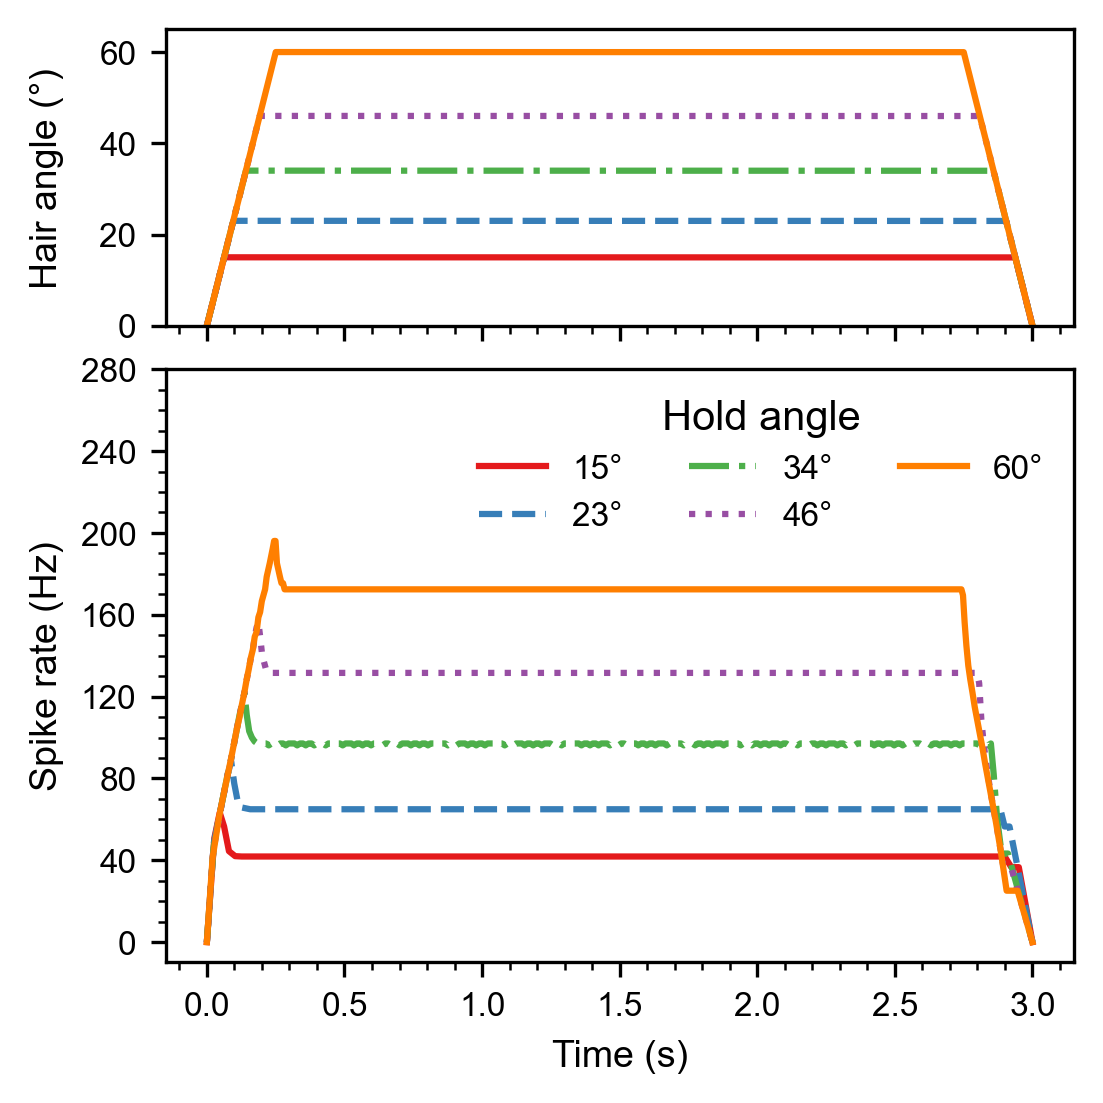

In [8]:
# Create figure and subplots
fig, (ax, ax2) = plt.subplots(2, figsize=(3.75*0.95, 3.75*0.95), gridspec_kw={'height_ratios': [1, 2]}, sharex=True)
plt.subplots_adjust(wspace=0, hspace=0.05)

# Plot hair angle and firing rate for each variable
for i in range(v_var.size):
    firing_rate, spike_index = get_firing_rate_ISI(spike_train[:, i, 1], sensory_parameters['dt'])
    ax.plot(time, input_ramp[:, i, 1] / I_phi, color=custom_colors[i], linestyle=custom_linestyles[i])
    ax2.plot(time[spike_index], firing_rate, color=custom_colors[i], linestyle=custom_linestyles[i])

# Set labels and limits for the plots
ax.set_ylabel("Hair angle (°)")
ax.set_ylim([0, 65])
ax.set_yticks([0, 20, 40, 60])

ax2.set_xlabel("Time (s)")
ax2.set_ylabel("Spike rate (Hz)")
ax2.set_yticks([0, 40, 80, 120, 160, 200, 240, 280])
ax2.minorticks_on()
ax2.legend(['15°', '23°', '34°', '46°', '60°'], frameon=False, ncol=3, title='Hold angle')

# Align y-axis labels
fig.align_ylabels([ax, ax2])

# Save
fig.tight_layout(pad=parameters['pad'])
fig.savefig('images/afferents/P1_fig3c.png')

In [ ]:
# Create figure and subplots
fig, (ax, ax2) = plt.subplots(2, figsize=(3.75*0.95, 3.75*0.95), gridspec_kw={'height_ratios': [1, 2]}, sharex=True)
plt.subplots_adjust(wspace=0, hspace=0.05)

# Plot hair angle and firing rate for each variable
for i in range(hold_angle_var.size):
    firing_rate, spike_index = get_firing_rate_ISI(spike_train[:, i, 0], sensory_parameters['dt'])
    ax.plot(time, input_ramp[:, i, 0] / I_phi, color=custom_colors[i], linestyle=custom_linestyles[i])
    ax2.plot(time[spike_index], firing_rate, color=custom_colors[i], linestyle=custom_linestyles[i])

# Set labels and limits for the plots
ax.set_ylabel("Hair angle (°)")
ax.set_ylim([0, 65])
ax.set_yticks([0, 20, 40, 60])

ax2.set_xlabel("Time (s)")
ax2.set_ylabel("Spike rate (Hz)")
ax2.set_yticks([0, 40, 80, 120, 160])
ax2.minorticks_on()
ax2.legend(['96 °/s', '188 °/s', '352 °/s', '604 °/s', '980 °/s'], frameon=False, ncol=1, title='Ramp speed', loc='lower center')

# Align y-axis labels
fig.align_ylabels([ax, ax2])

# Save
fig.tight_layout(pad=parameters['pad'])
fig.savefig('images/afferents/P1_fig2d.png')

#### General Phasic-Tonic Behavior of the Model (Supplementary Material)

The AdEx model can simulate a wide variety of phasic-tonic responses, with adjustable phasic peaks and tonic steady-state spike rates. This flexibility is demonstrated by varying the following parameters:

- **Increasing adaptation coupling factor \(a\)**: This increases adaptation, which lowers the steady-state frequency while maintaining a constant phasic peak strength.
- **Increasing adaptation coupling factor \(a\) and decreasing membrane capacitance \(C\)**: This combination modifies the phasic peak without altering the steady-state spike rate.
- **Increasing membrane capacitance \(C\)** with spike-triggered adaptation \(b\) set to 0: This yields fully tonic behavior, allowing variation in the steady-state spike rate without a phasic peak.


In [10]:
# Define sensory neuron parameters
sensory_parameters = {'C': 200e-12, 'g_L': 2e-9, 'E_L': -70e-3, 'DeltaT': 2e-3, 'a': 2e-9, 'V_T': -50e-3,
                      'tau_W': 50e-3, 'b': 264e-12, 'V_R': -70e-3, 'V_cut': -50e-3, 'n': 1, 'dt': 0.0001}

# Generate parameter values for 'a' to iterate over
a_values = np.linspace(0e-9, 121e-9, num=4)

# Prepare array to store spike train results
spike_train = np.empty((n_steps, a_values.size))

# Iterate over each value of 'a' and simulate neuron response
for j, a_value in enumerate(a_values):
    
    # Update 'a' parameter in sensory parameters
    sensory_parameters['a'] = a_value
    
    # Create instance and initialize
    sensory_neuron = AdEx(sensory_parameters)
    sensory_neuron.initialize_state()
    
    # Run the simulation
    for i in range(n_steps):
        _, spike_train[i, j] = sensory_neuron.forward(input_ramp[i, 3, 0])

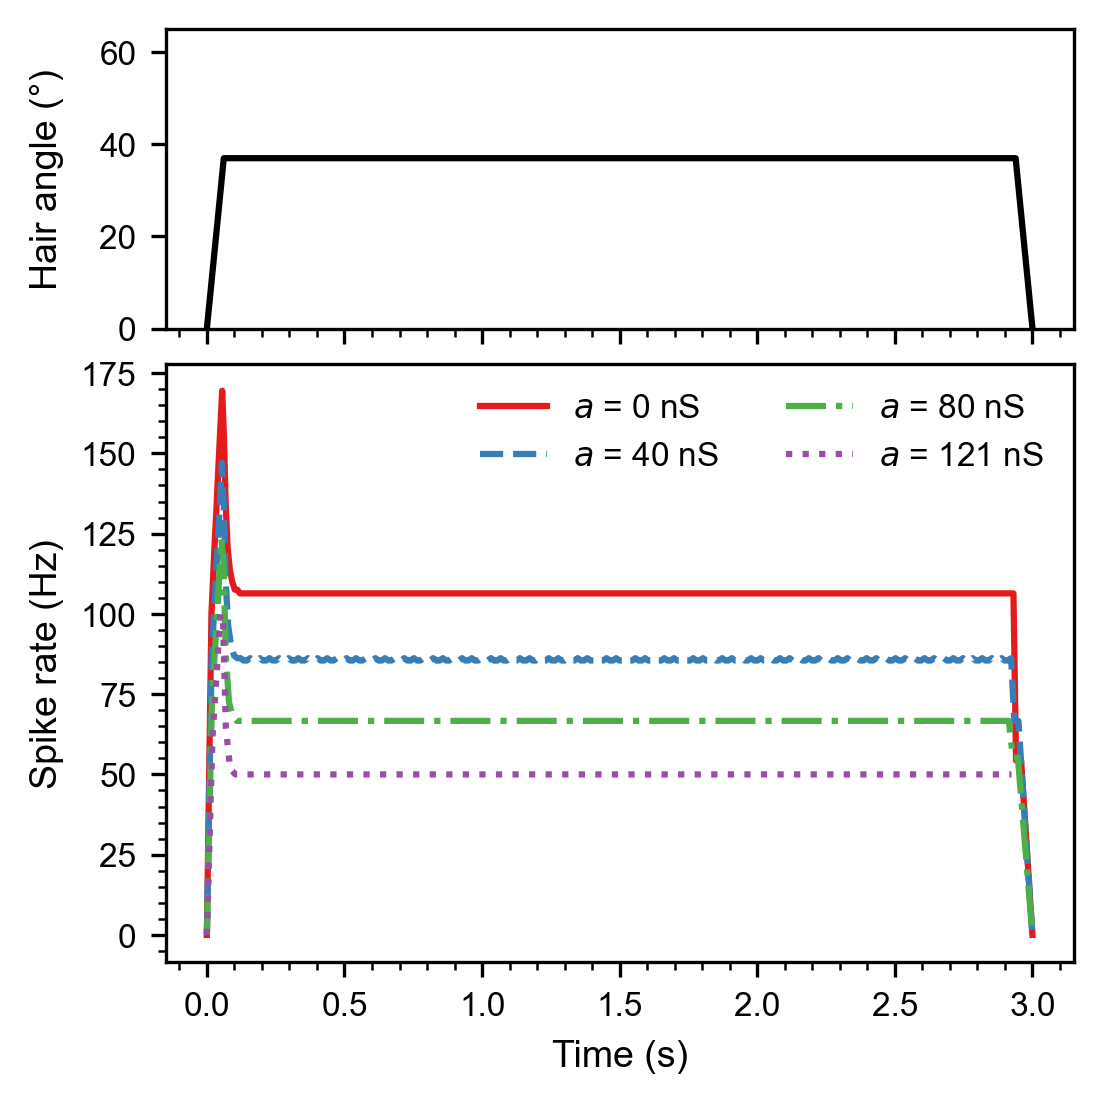

In [11]:
# Create subplots with specified configuration
fig, (ax, ax2) = plt.subplots(2, figsize=(3.75*0.95, 3.75*0.95), gridspec_kw={'height_ratios': [1, 2]}, sharex='all')
plt.subplots_adjust(wspace=0, hspace=0.05)

# Iterate over each parameter value in par_1
for i in range(a_values.size):
    firing_rate, spike_index = get_firing_rate_ISI(spike_train[:, i], sensory_parameters['dt'])
    
    # Plot firing rate vs. time
    if i == 3:
        ax2.plot(time[spike_index][:-1], firing_rate[:-1], color=custom_colors[i], linestyle=custom_linestyles[i], label=f'$a$ = {int(a_values[i]*1E9)} nS')
    else:
        ax2.plot(time[spike_index], firing_rate, color=custom_colors[i], linestyle=custom_linestyles[i], label=f'$a$ = {int(a_values[i]*1E9)} nS')

# Plot input ramp on the first subplot (ax)
ax.plot(time, input_ramp[:, i, 0] / I_phi, color='black')

# Set parameters for ax
ax.set_ylabel("Hair angle (°)")
ax.set_yticks([0, 10, 20, 30, 40])
ax.set_ylim([0, 65])
ax.set_yticks([0, 20, 40, 60])

# Set parameters for ax2
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("Spike rate (Hz)")
ax2.legend(fancybox=False, edgecolor='black', loc='upper right', frameon=False, ncol=2)
ax2.minorticks_on()

# Align y-axis labels between ax and ax2
fig.align_ylabels([ax, ax2])

# Adjust layout with specified padding
fig.tight_layout(pad=parameters['pad'])

# Save figure to specified path
fig.savefig('images/afferents/P1_S3.png')

In [12]:
# Define sensory neuron parameters
sensory_parameters = {'C': 200e-12, 'g_L': 2e-9, 'E_L': -70e-3, 'DeltaT': 2e-3, 'a': 2e-9, 'V_T': -50e-3,
                      'tau_W': 50e-3, 'b': 264e-12, 'V_R': -70e-3, 'V_cut': -50e-3, 'n': 1, 'dt': 0.0001}

# Generate parameter values for 'a' to iterate over
C_values = np.linspace(200e-12, 500e-12, num=4)
a_values = np.linspace(0e-9, 51e-9, num=4)

# Prepare array to store spike train results
spike_train = np.empty((n_steps, a_values.size))

# Iterate over each value of 'a' and simulate neuron response
for j in range(a_values.size):
    
    # Update 'a' parameter in sensory parameters
    sensory_parameters['a'] = a_values[j]
    sensory_parameters['C'] = C_values[-j-1]
    
    # Create instance and initialize
    sensory_neuron = AdEx(sensory_parameters)
    sensory_neuron.initialize_state()
    
    # Run the simulation
    for i in range(n_steps):
        _, spike_train[i, j] = sensory_neuron.forward(input_ramp[i, 3, 0])

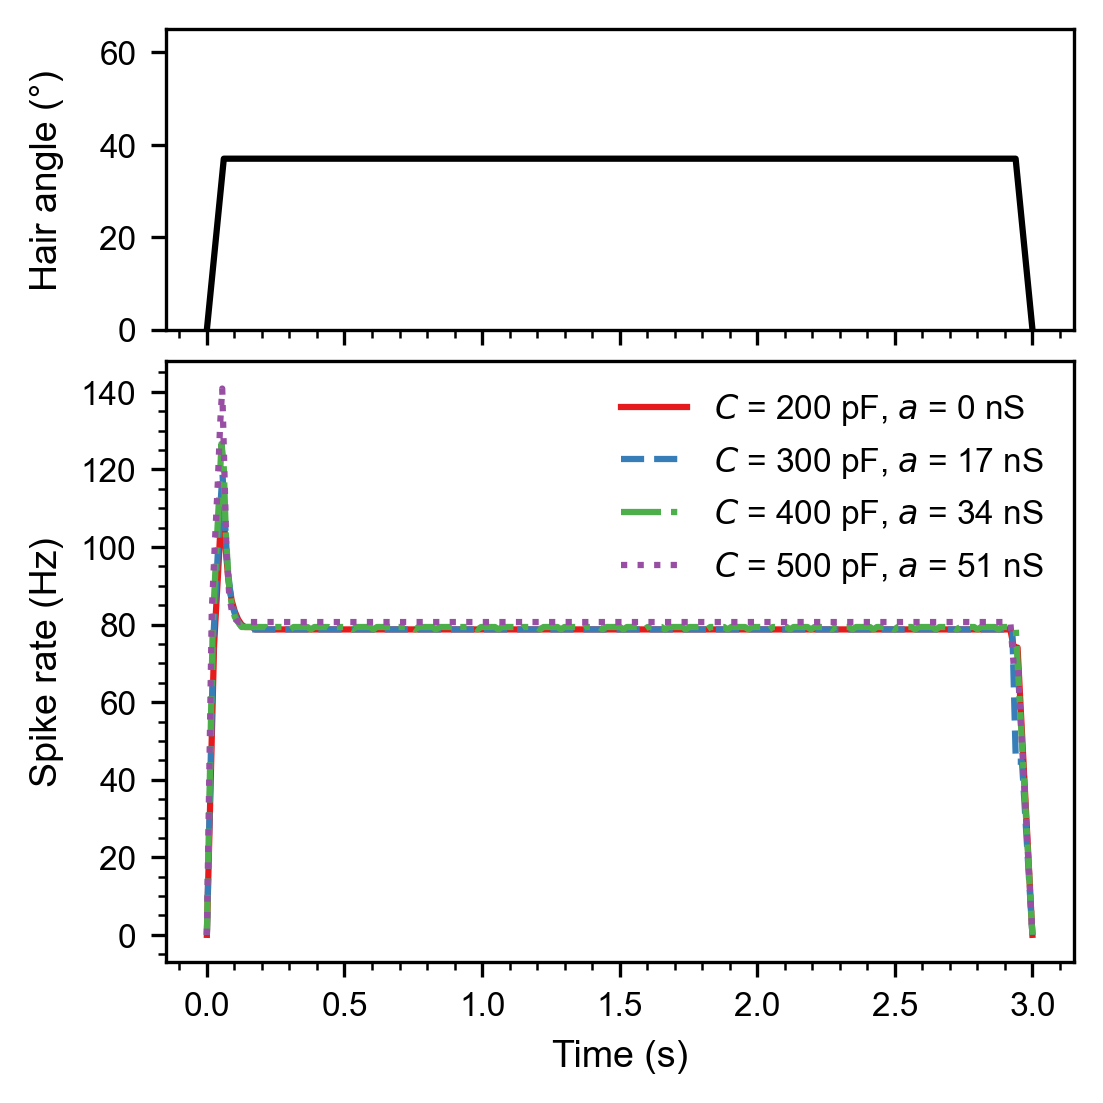

In [13]:
# Create subplots with specified configuration
fig, (ax, ax2) = plt.subplots(2, figsize=(3.75*0.95, 3.75*0.95), gridspec_kw={'height_ratios': [1, 2]}, sharex='all')
plt.subplots_adjust(wspace=0, hspace=0.05)

# Plot firing rate vs. time for each value in a_values
for i in range(a_values.size):
    firing_rate, spike_index = get_firing_rate_ISI(spike_train[:, i], sensory_parameters['dt'])
    ax2.plot(time[spike_index], firing_rate, color=custom_colors[i], linestyle=custom_linestyles[i], label=f'$C$ = {int(C_values[i]*1E12)} pF, $a$ = {int(a_values[i]*1E9)} nS')

# Plot input ramp on the first subplot (ax)
ax.plot(time, input_ramp[:, i, 0] / I_phi, color='black')

# Set labels and ticks for ax (top subplot)
ax.set_ylabel("Hair angle (°)")
ax.set_yticks([0, 10, 20, 30, 40])
ax.set_ylim([0, 65])
ax.set_yticks([0, 20, 40, 60])

# Set labels and ticks for ax2 (bottom subplot)
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("Spike rate (Hz)")
ax2.legend(frameon=False)

# Enable minor ticks on ax2 (bottom subplot)
ax2.minorticks_on()

# Align y-axis labels between ax and ax2
fig.align_ylabels([ax, ax2])

# Adjust layout
fig.tight_layout()

#save
fig.tight_layout(pad=parameters['pad'])
fig.savefig('images/afferents/P1_S4.png')

In [14]:
fig.tight_layout(pad=parameters['pad'])
fig.savefig('images/afferents/P1_S4.png')

In [15]:
# Define sensory neuron parameters
sensory_parameters = {'C': 200e-12, 'g_L': 2e-9, 'E_L': -70e-3, 'DeltaT': 2e-3, 'a': 2e-9, 'V_T': -50e-3,
                      'tau_W': 50e-3, 'b': 0, 'V_R': -70e-3, 'V_cut': -50e-3, 'n': 1, 'dt': 0.0001}

# Generate parameter values for 'a' to iterate over
C_values = np.linspace(200e-12, 500e-12, num=4)

# Prepare array to store spike train results
spike_train = np.empty((n_steps, a_values.size))

# Iterate over each value of 'a' and simulate neuron response
for j, C_value in enumerate(C_values):
    
    # Update 'a' parameter in sensory parameters
    sensory_parameters['C'] = C_value
    
    # Create instance and initialize
    sensory_neuron = AdEx(sensory_parameters)
    sensory_neuron.initialize_state()
    
    # Run the simulation
    for i in range(n_steps):
        _, spike_train[i, j] = sensory_neuron.forward(input_ramp[i, 3, 0])

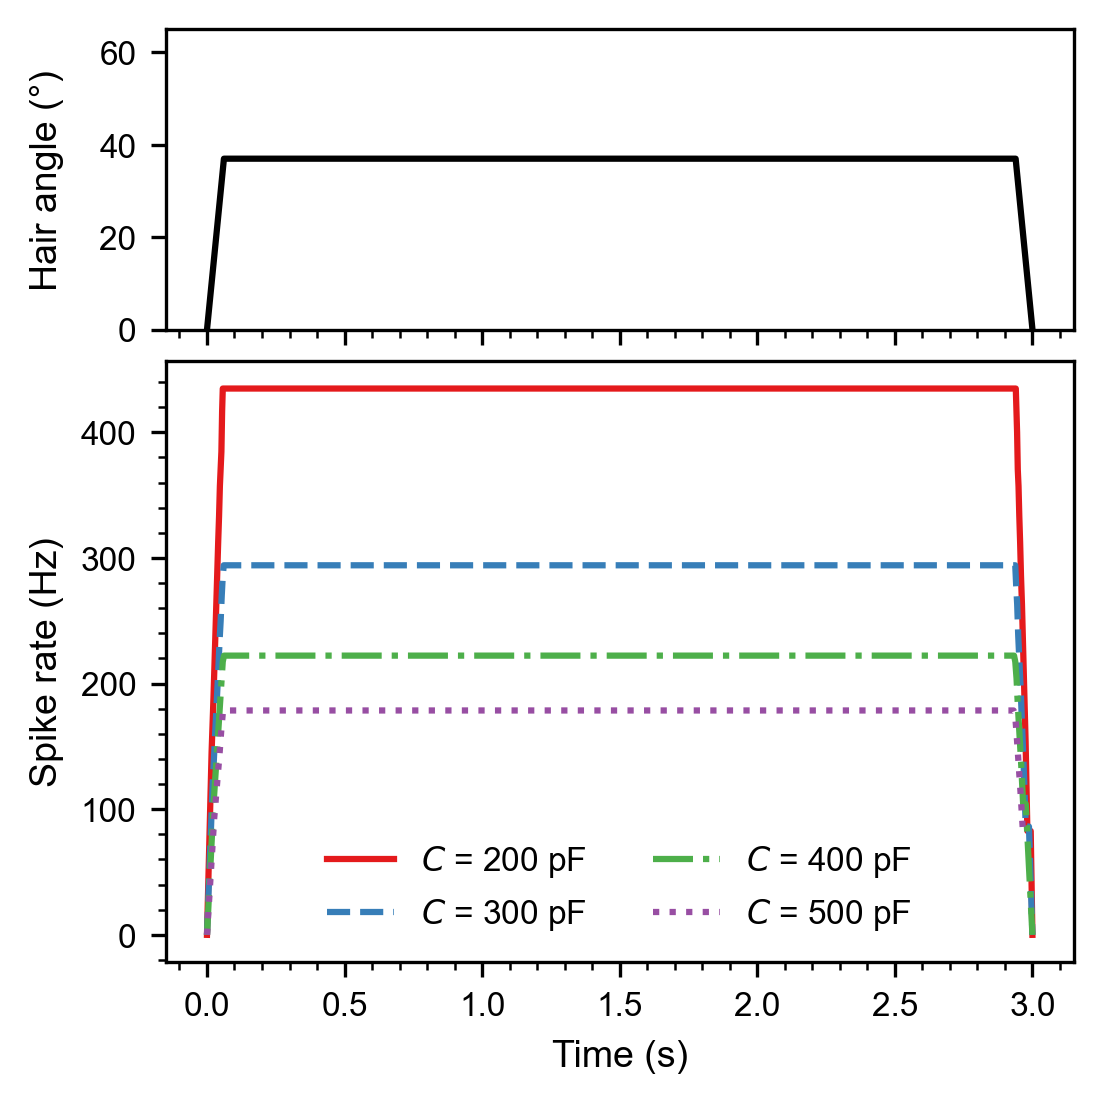

In [16]:
# Create subplots with specified configuration
fig, (ax, ax2) = plt.subplots(2, figsize=(3.75*0.95, 3.75*0.95), gridspec_kw={'height_ratios': [1, 2]}, sharex='all')
plt.subplots_adjust(wspace=0, hspace=0.05)

# Iterate over each parameter value in C_values
for i in range(C_values.size):
    firing_rate, spike_index = get_firing_rate_ISI(spike_train[:, i], sensory_parameters['dt'])
    
    # Plot firing rate vs. time
    if i == 3:
        ax2.plot(time[spike_index][:-1], firing_rate[:-1], color=custom_colors[i], linestyle=custom_linestyles[i], label=f'$C$ = {int(C_values[i]*1E12)} pF')
    else:
        ax2.plot(time[spike_index], firing_rate, color=custom_colors[i], linestyle=custom_linestyles[i], label=f'$C$ = {int(C_values[i]*1E12)} pF')

# Plot input ramp on the first subplot (ax)
ax.plot(time, input_ramp[:, i, 0] / I_phi, color='black')

# Set parameters for ax
ax.set_ylabel("Hair angle (°)")
ax.set_yticks([0, 10, 20, 30, 40])
ax.set_ylim([0, 65])
ax.set_yticks([0, 20, 40, 60])

# Set parameters for ax2
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("Spike rate (Hz)")
ax2.legend(fancybox=False, edgecolor='black', loc='lower center', frameon=False, ncol=2)
ax2.minorticks_on()

# Align y-axis labels between ax and ax2
fig.align_ylabels([ax, ax2])

# Adjust layout with specified padding
fig.tight_layout(pad=parameters['pad'])

# Save figure to specified path
fig.savefig('images/afferents/P1_S5.png')

#### Applying Hair Field and Sensory Neuron Model to Experimental Joint Data

We are analyzing two sets of experimental data:

1. 78 trials of stick insects walking on a flat surface, each lasting 5 seconds.
2. 21 trials of stick insects encountering 2 steps of 48mm on a flat surface, each lasting 25 seconds.

Each trial includes 18 time courses of joint angles, covering three joints in six legs. Each joint is equipped with a binary hair field comprising 50 hairs in each direction, totaling 100 hairs per joint. Each hair is associated with its own mechanosensory neuron.

In [17]:
# Define sensory neuron parameters for hair rows in stick insect joints, each of the 18 joints in a stick insect is equipped with two rows of 50 hairs, resulting in a total of 1800 mechanosensory neurons.
sensory_parameters = {'C': 200e-12, 
                      'g_L': 2e-9, 
                      'E_L': -70e-3, 
                      'DeltaT': 2e-3, 
                      'a': 2e-9, 
                      'V_T': -50e-3,
                      'tau_W': 50e-3, 
                      'b': 264e-12, 
                      'V_R': -70e-3, 
                      'V_cut': -50e-3, 
                      'n': parameters['N_HAIRS']*18*2,  # 1800 neurons
                      'dt': constants['dt']}

# Add parameters to AdEx neuron
sensory_neuron = AdEx(sensory_parameters)

In [18]:
def run_sensory(joint_angles, n_simulations, n_steps):
    
    # Initialize spike_sensory array to store sensory neuron spike trains
    spike_sensory = np.empty((n_steps, constants['N_ANGLES'] * parameters['N_HAIRS'] * 2, n_simulations), dtype=np.uint8)

    # Loop over each simulation trial
    for k in tqdm(range(n_simulations)):
        
        # Get joint angles for current simulation
        joint_angle = joint_angles[:, :, k]
        
        # Initialize array to store hair angles
        hair_angles = np.empty((joint_angle.shape[0], 2 * joint_angle.shape[1] * parameters['N_HAIRS']), dtype=np.float32)
        
        # Parameters for hair field simulation
        hair_field_parameters = {
            'N_hairs': parameters['N_HAIRS'],                   # Number of hairs per hair field (2x per joint)
            'min_joint_angle': np.amin(joint_angle, axis=0),    # Minimum joint angle across time for each joint (degrees)
            'max_joint_angle': np.amax(joint_angle, axis=0),    # Maximum joint angle across time for each joint (degrees)
            'max_angle': 90,                                    # Maximum angle for hair field (degrees)
            'overlap': 0.1                                      # Degree of overlap between individual hairs (degrees)
        }
        
        # Loop over each joint and leg (in total 18 angles)
        for i in range(constants['N_ANGLES']):
            
            # Create HairField instance with current parameters
            hair_field = HairField(hair_field_parameters)
            hair_field.reset_max_min(i)  # Reset max/min angles for current joint
            hair_field.get_double_receptive_field()  # Compute double receptive field
            
            # Compute hair angles based on joint angles
            hair_angles[:, i * 2 * parameters['N_HAIRS']: 2 * parameters['N_HAIRS'] + i * 2 * parameters['N_HAIRS']] = (
                    hair_field.get_hair_angle(joint_angle[:, i]) * I_phi)  # convert hair angles to currents in nA range
            
        # Initialize sensory neuron and state
        sensory_neuron.initialize_state()
        
        # Simulate neuron response to hair angles
        for i in range(n_steps):
            _, spike_sensory[i, :, k] = sensory_neuron.forward(hair_angles[i, :])
    
    return spike_sensory

In [19]:
# Load joint angle data from files
with open('temp_data/joint_angles', 'rb') as file:
    joint_angles = np.load(file)
    
with open('temp_data/joint_angles_step', 'rb') as file:
    joint_angles_step = np.load(file)

# Run sensory neuron simulations for regular trials (78) and trials (21) with steps
spike_sensory = run_sensory(joint_angles, np.min((parameters['N_SIMULATIONS'], 78)), constants['N_STEPS'])
spike_sensory_step = run_sensory(joint_angles_step, np.min((parameters['N_SIMULATIONS'], 21)), constants['N_STEPS_STEP'])

# Save sensory neuron spike data if save_data parameter is set to True 
if parameters['save_data']:
    with open('temp_data/spike_sensory', 'wb') as file:
        np.save(file, spike_sensory)
        
    with open('temp_data/spike_sensory_step', 'wb') as file:
        np.save(file, spike_sensory_step)

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

#### Testing & Visualization: Mechanosensory Neuron Response to Joint Angle Stimulus

Here are several plots that illustrate how mechanosensory neurons respond to experimental joint angle stimuli.

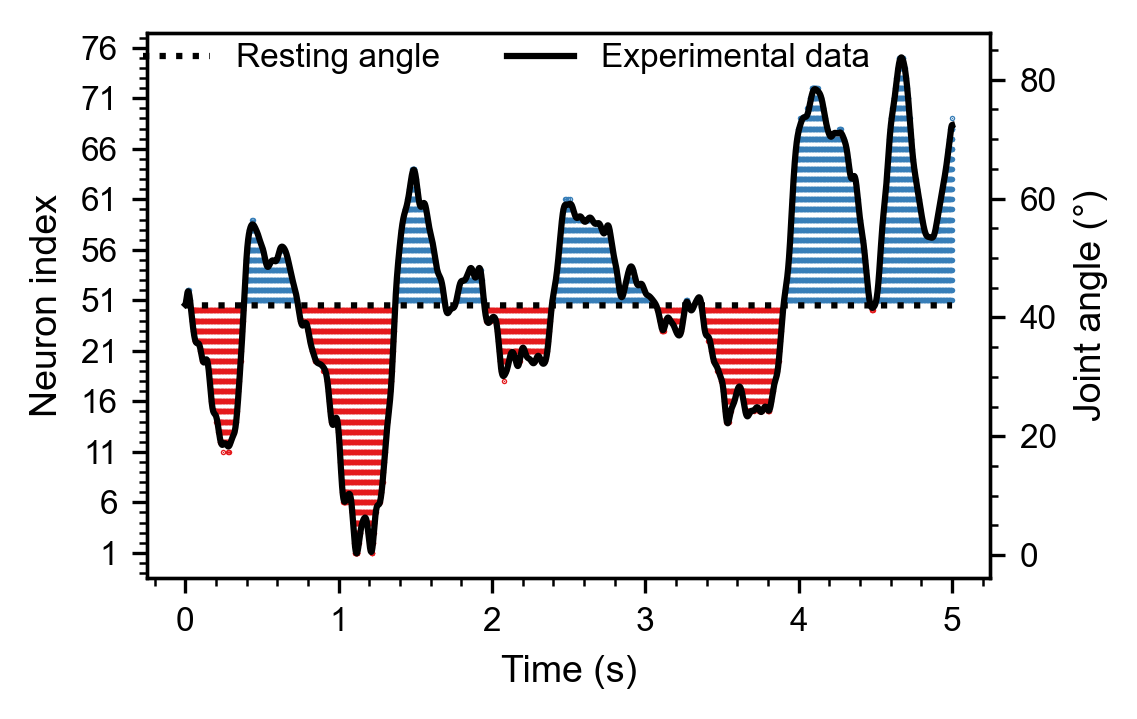

In [20]:
# Generate time array
time = np.linspace(0, constants['T_TOTAL'], num=constants['N_STEPS'])

# Create figure and axes
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

# Constants and parameters
N_half = parameters['N_HAIRS'] // 2
diff = joint_angles[:, 0, 0].max() - joint_angles[:, 0, 0].min()

# Convert spike_sensory to float and replace zeros with NaN for plotting
spike_sensory = spike_sensory[:, :, 0].astype(np.float32)
spike_sensory[spike_sensory == 0] = np.nan

# Plot experimental joint angle data
ax2.plot(time, joint_angles[:, 0, 0], color='black', label='Experimental data')

# Scatter plot for spikes in negative and positive domains
for i in range(N_half):
    ax1.scatter(time, (-i + N_half) * spike_sensory[:, i + N_half], color=custom_colors[0], s=0.1)
    ax1.scatter(time, (1 + i + N_half) * spike_sensory[:, i + N_half + parameters['N_HAIRS']], color=custom_colors[1], s=0.1)

# Dotted line for resting angle
ax1.plot(time, np.full(time.shape, N_half + 0.5), linestyle='dotted', color='black', label='Resting angle')

# Set axis limits, labels and ticks (ax1)
ax1.set_xlabel("Time (s)")
ax1.set_ylim(1 - parameters['N_HAIRS'] * 0.05, parameters['N_HAIRS'] * 1.05)
ax1.set_ylabel("Neuron index")
ax1.set_yticks(np.arange(1, parameters['N_HAIRS'] + 2)[::5])
ax1.minorticks_on()

# Set axis limits, labels and ticks (ax2)
ax2.set_ylabel("Joint angle (°)")
ax2.set_ylim(joint_angles[:, 0, 0].min() - 0.05 * diff, joint_angles[:, 0, 0].max() + 0.05 * diff)
ax2.minorticks_on()

# Legend settings
fig.legend(frameon=False, ncol=2, bbox_to_anchor=[0.80, 1.01])

# Customize y-axis tick labels
labels = [1, 6, 11, 16, 21, 51, 56, 61, 66, 71, 76]
ax1.set_yticklabels(labels)

# Adjust layout and save figure
fig.tight_layout(pad=parameters['pad'])
fig.savefig('images/afferents/P1_fig4a.png')

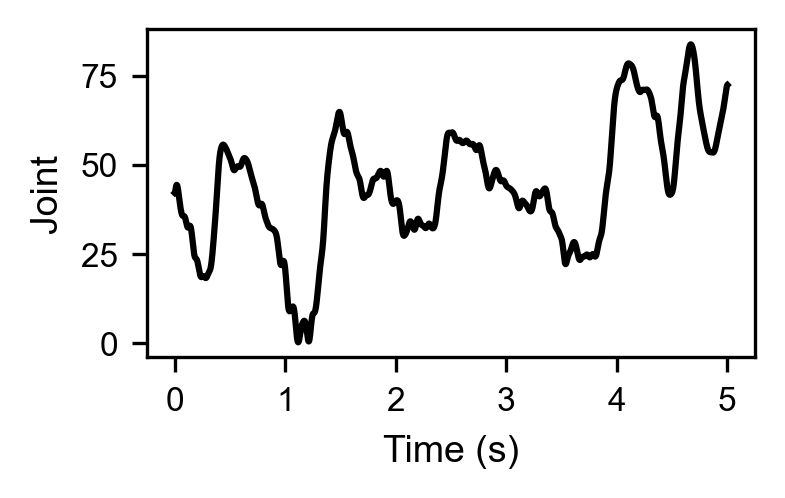

In [21]:
# Create figure and axis with specified aspect ratio (golden ratio)
fig, ax = plt.subplots(figsize=(2.5, 2.5 / 1.61803398875))

# Plot joint angle data
ax.plot(time, joint_angles[:, 0, 0], color='black')

# Set labels for x and y axes
ax.set_xlabel("Time (s)")
ax.set_ylabel("Joint angle (°)")

fig.tight_layout(pad=parameters['pad'])
fig.savefig('images/afferents/P1_fig1c.png')

#### Visualization of the AdEx Model with a Sustained Input Current (Supplementary Material)

This figure illustrates the response of the AdEx neuron model to a sustained input current, highlighting key membrane dynamics and spike generation. 

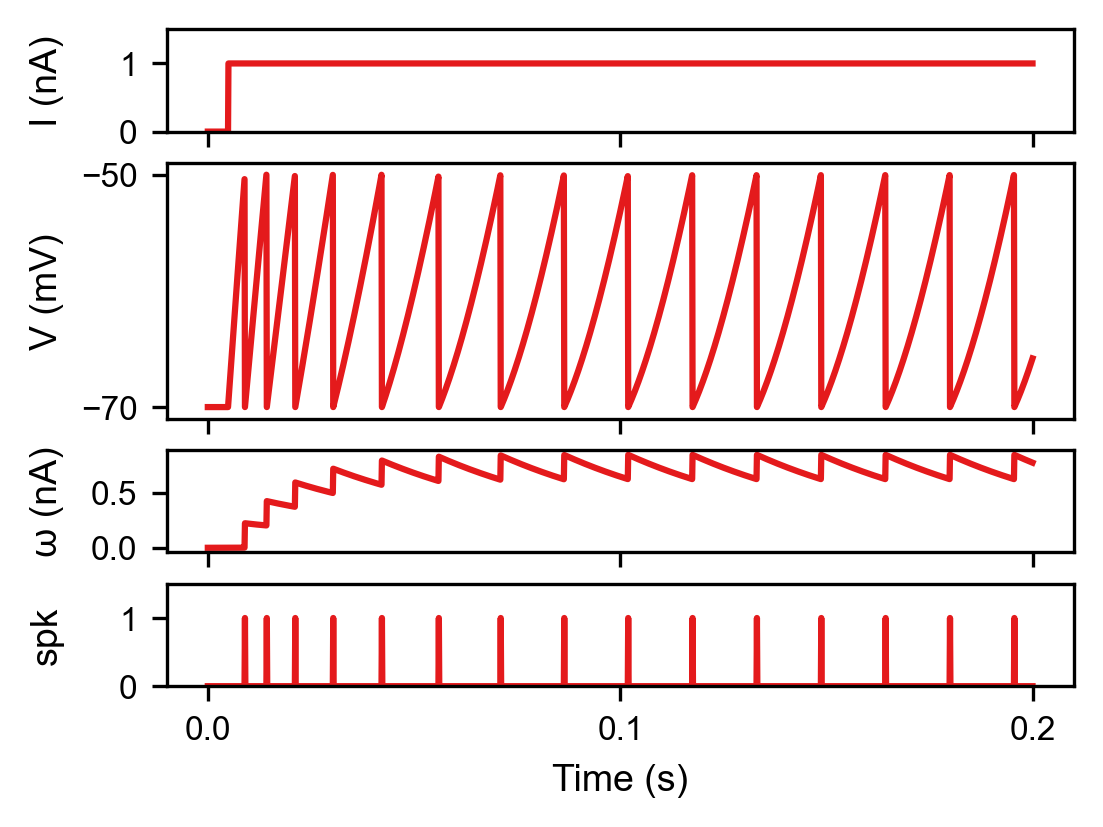

In [22]:
# Create subplots
fig, [ax, ax2, ax3, ax4] = plt.subplots(4, figsize=(3.75*0.95, 1.2*0.95*3.75/1.61803398875), gridspec_kw={'height_ratios': [1, 2.5, 1, 1]}, sharex='all')

# Store axes in a list for easier iteration
axs = [ax, ax2, ax3, ax4]

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0, hspace=0.05)

# Define sensory neuron parameters
sensory_parameters = {'C': 200e-12, 'g_L': 2e-9, 'E_L': -70e-3, 'DeltaT': 2e-3, 'a': 2e-9, 'V_T': -50e-3,
                      'tau_W': 50e-3, 'b': 221e-12, 'V_R': -70e-3, 'V_cut': -50e-3, 'n': 1, 'dt': 0.0001}

# Initialize AdEx neuron model
sensory_neuron = AdEx(sensory_parameters)
sensory_neuron.initialize_state()

# Generate input current pulse (333 hz)
input = np.zeros(2000)
input[50:] = 1e-9  # Set the input current from index 50 onwards

# Arrays to store simulation results
voltage, spikes, time, omega = np.zeros(input.size), np.zeros(input.size), np.zeros(input.size), np.zeros(input.size)

# Simulate neuron response to input current pulse
for i in range(input.size):
    voltage[i], spikes[i] = sensory_neuron.forward(input[i])
    omega[i] = sensory_neuron.state.w
    time[i] = i * sensory_parameters['dt']

# Plot input current
ax.plot(time, input * 1e9, color=custom_colors[0])    
ax.set_ylabel("I (nA)")
ax.set_yticks([0, 1])
ax.set_xticks([0, 0.1, 0.2])
ax.set_ylim(0, 1.5)

# Plot membrane voltage
ax2.plot(time, voltage * 1000, color=custom_colors[0])
ax2.set_ylabel("V (mV)")
ax2.set_yticks([-70, -50])

# Plot adaptation variable
ax3.plot(time, omega * 1e9, color=custom_colors[0])
ax3.set_ylabel("ω (nA)")

# Plot spikes
ax4.plot(time, spikes, color=custom_colors[0])
ax4.set_ylabel("spike")
ax4.set_yticks([0, 1])
ax4.set_xlabel("Time (s)")
ax4.set_ylim(0, 1.5)

# Align y-labels for all subplots
fig.align_ylabels([ax, ax2, ax3, ax4])

# Adjust layout with specified padding
fig.tight_layout(pad=parameters['pad'])

# Save the figure as an image file
fig.savefig('images/afferents/P1_S1.png')